## **ASSIGNMENT 2 - KAGGLE COMPETITION**

# **Porto Seguro's Safe Driver Prediction**

**ABSTRACT**

Nothing ruins the thrill of buying a brand new car more quickly than seeing your new insurance bill. The sting’s even more painful when you know you’re a good driver. It doesn’t seem fair that you have to pay so much if you’ve been cautious on the road for years.

Porto Seguro, one of Brazil’s largest auto and homeowner insurance companies, completely agrees. Inaccuracies in car insurance company’s claim predictions raise the cost of insurance for good drivers and reduce the price for bad ones.

In this competition, you’re challenged to build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year. While Porto Seguro has used machine learning for the past 20 years, they’re looking to Kaggle’s machine learning community to explore new, more powerful methods. A more accurate prediction will allow them to further tailor their prices, and hopefully make auto insurance coverage more accessible to more drivers.



In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

import time

random_state = 6
np.random.seed(random_state)
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
get_ipython().run_line_magic('matplotlib', 'inline')

# latex parameter
font = {
    'family': 'serif', 
    'serif': ['Computer Modern Roman'],
    'weight' : 'regular',
    'size'   : 18
    }

plt.rc('font', **font)
plt.rc('text', usetex=False)
# plt.style.use('classic')

color_map = 'viridis'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
cd Colab\ Notebooks

/content/drive/My Drive/Colab Notebooks


In [7]:
df_train = pd.read_csv('train.csv/train.csv', na_values=-1)
df_test = pd.read_csv('test.csv/test.csv', na_values=-1)

### Check if both test and train have the same shape

In [8]:
print('Training data shape: {}'.format(df_train.shape))
print('Training data shape: {}'.format(df_test.shape))

Training data shape: (595212, 59)
Training data shape: (892816, 58)


### Check if there are any missing values

In [9]:
print('Is null on train: {}'.format(df_train.isnull().any().any()))
print('Is null on test: {}'.format(df_test.isnull().any().any()))

Is null on train: True
Is null on test: True


### Descriptive statistics

In [10]:
df_train.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,594996.000000,595212.000000,595129.000000,589403.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,487440.000000,595105.000000,595207.000000,183981.000000,595212.000000,328661.000000,595212.000000,583723.000000,595212.000000,594643.000000,595212.000000,595212.000000,595207.000000,595211.000000,595212.000000,552592.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.359799,4.423318,0.416992,0.419038,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.012451,7.299922,0.660823,0.121081,0.153446,0.610991,0.439184,0.894047,8.297605,0.829947,0.601741,0.725192,0.525365,6.555340,0.947621,0.832080,1.331118,0.992136,62.215674,2.346100,0.379947,0.813265,0.374691,3.065899,0.449756,0.449589,0.449849,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.663193,2.699902,0.493062,1.350023,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.127545,3.546042,0.473430,0.326222,0.360417,0.287643,0.404264,0.345413,2.505396,0.375680,0.489541,2.153463,0.499357,5.501445,0.222791,0.373796,0.976559,0.091619,33.012455,0.832495,0.058300,0.224588,0.045610,0.731366,0.287198,0.286893,0.287153,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.061237,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.100000,0.250619,0.109545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.400000,0.200000,0.633443,7.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000,2.000000,0.316228,0.670867,0.350428,2.828427,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.700000,0.300000,0.801561,7.000000,1.000000,1.000000,0.000000,1.000000,7.000000,1.000000,1.0000

### Heatmap 

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


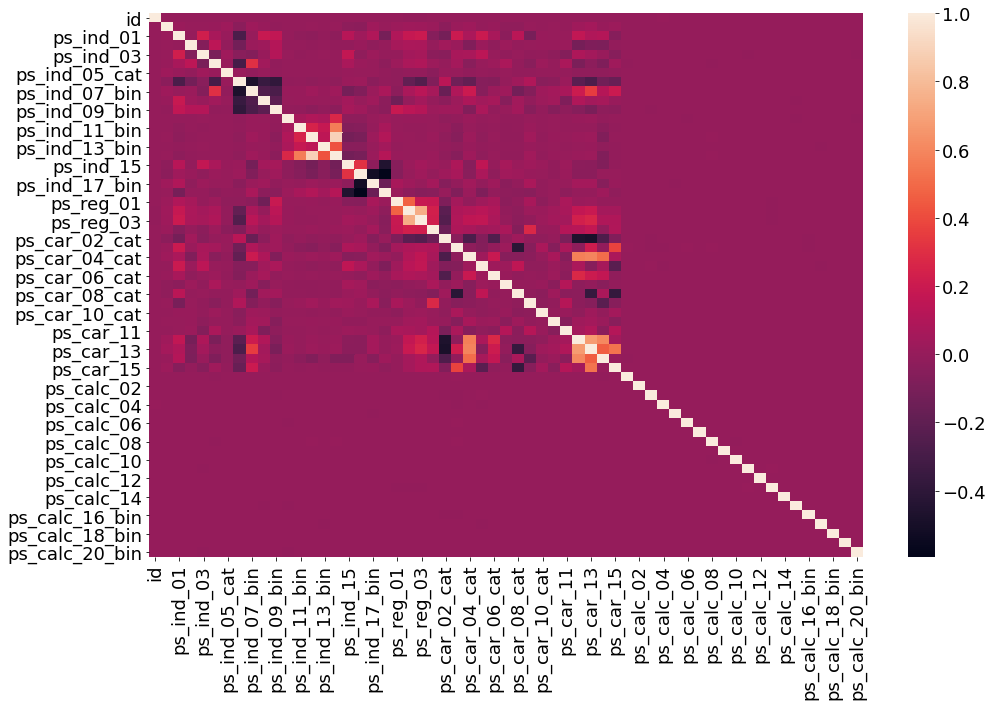

In [11]:
import seaborn as sns
cor = df_train.corr()
plt.figure(figsize=(16,10))
sns.heatmap(cor)

#### Since 'ps_calc' features do not show any have zero relationship with other features
#### We can delete them.

In [12]:
col_to_drop = list(df_train.columns[df_train.columns.str.startswith('ps_calc_')])
df_train = df_train.drop(col_to_drop, axis=1)  
df_test = df_test.drop(col_to_drop, axis=1)

## Work with missing values

In [13]:
def get_missing_features(df):
    missings = pd.DataFrame([], columns=['feature', 'no_recoreds', 'percentage'])
    total_rows = df.shape[0]
    index = 0
    for feature in list(df):
        total_nulls = df[feature].isnull().sum()
        if total_nulls > 0:
            missings_perc = total_nulls / total_rows
            missings.loc[index] = [feature, total_nulls, missings_perc]
            index += 1
    missings = missings.sort_values('no_recoreds', ascending=False)
    return missings

In [14]:
df_missings = get_missing_features(df_train)
print(df_missings)

          feature no_recoreds  percentage
6   ps_car_03_cat      411231    0.690898
7   ps_car_05_cat      266551    0.447825
3       ps_reg_03      107772    0.181065
12      ps_car_14       42620    0.071605
8   ps_car_07_cat       11489    0.019302
2   ps_ind_05_cat        5809    0.009760
9   ps_car_09_cat         569    0.000956
0   ps_ind_02_cat         216    0.000363
4   ps_car_01_cat         107    0.000180
1   ps_ind_04_cat          83    0.000139
5   ps_car_02_cat           5    0.000008
10      ps_car_11           5    0.000008
11      ps_car_12           1    0.000002


### Bar plot of missing features

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


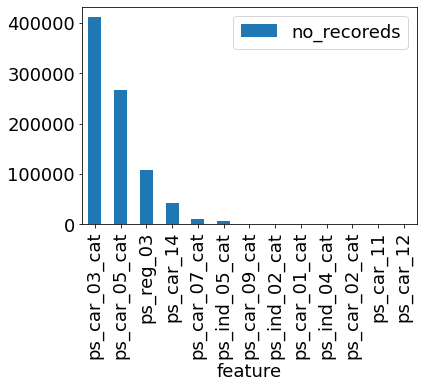

In [15]:
df_missings.plot(x='feature', y='no_recoreds', kind='bar', )

**Treat missing values by mode of the column**

In [16]:
for i, feature in enumerate(list(df_train.drop(['id'], axis=1))):
    if df_train[feature].isnull().sum() > 0:
        df_train[feature].fillna(df_train[feature].mode()[0],inplace=True)

for i, feature in enumerate(list(df_test.drop(['id'], axis=1))):
    if df_test[feature].isnull().sum() > 0:
        df_test[feature].fillna(df_test[feature].mode()[0],inplace=True)

### Check if there are any missing values

In [17]:
get_missing_features(df_train)
get_missing_features(df_test)

,feature,no_recoreds,percentage


## Check category features of the dataset

In [18]:
cat_cols = [col for col in df_train.columns if '_cat' in col]
dummed_cols = []

for cat_col in cat_cols:
    unique_values = len(np.unique(df_train[cat_col]))
    if unique_values < 50:
        dummed_cols.append(cat_col)
    print('{} has {} unique values'.format(cat_col, unique_values))

ps_ind_02_cat has 4 unique values
ps_ind_04_cat has 2 unique values
ps_ind_05_cat has 7 unique values
ps_car_01_cat has 12 unique values
ps_car_02_cat has 2 unique values
ps_car_03_cat has 2 unique values
ps_car_04_cat has 10 unique values
ps_car_05_cat has 2 unique values
ps_car_06_cat has 18 unique values
ps_car_07_cat has 2 unique values
ps_car_08_cat has 2 unique values
ps_car_09_cat has 5 unique values
ps_car_10_cat has 3 unique values
ps_car_11_cat has 104 unique values


## Transform category features to dummies

In [19]:
id_test = df_test['id'].values
y = df_train['target'].values

df_train = df_train.drop(['target','id'], axis = 1)
df_test = df_test.drop(['id'], axis = 1)

cat_features = [a for a in df_train.columns if a.endswith('cat')]

for column in cat_features:
    temp = pd.get_dummies(pd.Series(df_train[column]))
    df_train = pd.concat([df_train,temp],axis=1)
    df_train = df_train.drop([column],axis=1)
    
for column in cat_features:
    temp = pd.get_dummies(pd.Series(df_test[column]))
    df_test = pd.concat([df_test,temp],axis=1)
    df_test = df_test.drop([column],axis=1)

print(df_train.values.shape, df_test.values.shape)

(595212, 198) (892816, 198)


### Gini coeficient 

In [20]:
# from https://www.kaggle.com/mashavasilenko/
# porto-seguro-xgb-modeling-and-parameters-tuning
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini


def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]

def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

### Ensembling

In [21]:
from sklearn.model_selection import StratifiedKFold

class Create_ensemble(object):
    def __init__(self, n_splits, base_models):
        self.n_splits = n_splits
        self.base_models = base_models

    def predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=random_state).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        
        for i, clf in enumerate(self.base_models):
            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, valid_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_valid = X[valid_idx]
                y_valid = y[valid_idx]
                
                clf.fit(X_train, y_train)
                valid_pred = clf.predict_proba(X_valid)[:,1]
                S_train[valid_idx, i] = valid_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            
            print( "\nTraining Gini for model {} : {}".format(i, eval_gini(y, S_train[:,i])))
            S_test[:, i] = S_test_i.mean(axis=1)
            
        return S_train, S_test

## APPROACH 1 : Lightbm model

In [22]:
# LightGBM params
lgb_params = {}
lgb_params['learning_rate'] = 0.02
lgb_params['n_estimators'] = 700
lgb_params['max_bin'] = 15
lgb_params['subsample'] = 0.8
lgb_params['subsample_freq'] = 10
lgb_params['colsample_bytree'] = 0.8   
lgb_params['min_child_samples'] = 800
lgb_params['random_state'] = random_state
lgb_params['scale_pos_weight'] = 3

lgb_params2 = {}
lgb_params2['learning_rate'] = 0.02
lgb_params2['n_estimators'] = 900
lgb_params2['max_bin'] = 20
lgb_params2['subsample'] = 0.8
lgb_params2['subsample_freq'] = 10
lgb_params2['colsample_bytree'] = 0.8   
lgb_params2['min_child_samples'] = 600
lgb_params2['random_state'] = random_state
lgb_params2['scale_pos_weight'] = 3

lgb_model = LGBMClassifier(**lgb_params)
lgb_model2 = LGBMClassifier(**lgb_params2)

In [23]:
lgb_stack = Create_ensemble(n_splits = 5, base_models = [lgb_model, lgb_model2])        
X = df_train
Y = y
T = df_test
lgb_train_pred, lgb_test_pred = lgb_stack.predict(X, Y, T)


Training Gini for model 0 : 0.2845824882508221

Training Gini for model 1 : 0.28324784236249323


In [24]:
# Create submission file
sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = lgb_test_pred.mean(axis=1)
#sub.to_csv('lightgbm_submit_ensemble_features.csv', float_format='%.6f', index=False)
sub.to_csv('Approach1.csv', float_format='%.6f', index=False)

## correlation among the model results

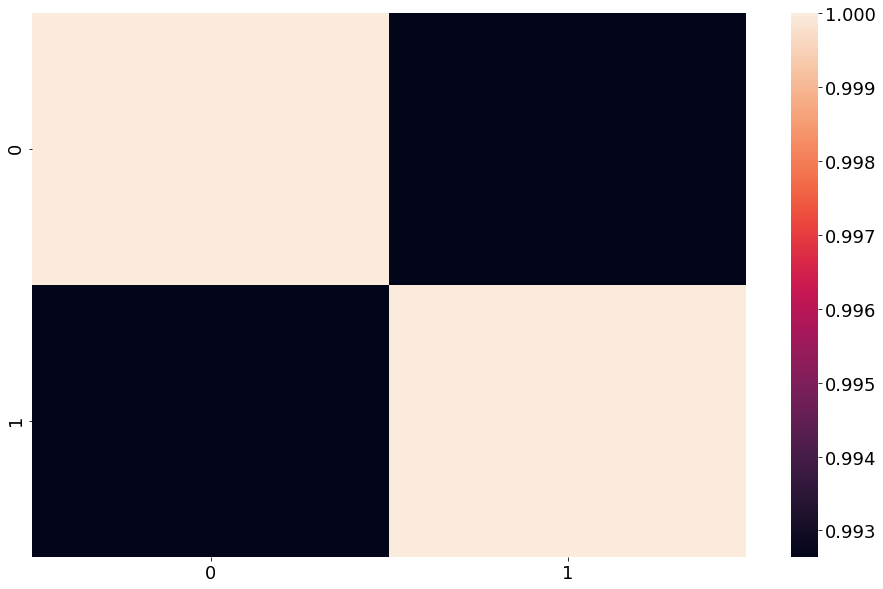

In [25]:
import seaborn as sns
test_pred_df = pd.DataFrame(data = lgb_test_pred)
cor = test_pred_df.corr()
plt.figure(figsize=(16,10))
sns.heatmap(cor)

## EDA

In [26]:
%load_ext autoreload
%autoreload 2

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
%matplotlib inline

import pandas as pd

import numpy as np

import sklearn
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn import metrics

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from IPython.display import display


from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [27]:
PATH = "train.csv/train.csv"
data_raw= pd.read_csv(f'{PATH}', low_memory=False)

In [28]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)
display_all(data_raw.head(5))

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


OBSERVATIONS FROM THE DATA

* Few groups are defined and features that belongs to these groups include patterns in the name (ind, reg, car, calc).

* The ind indicates most probably individual, reg is probably registration, car is self-explanatory, calc suggests a calculated field

* The postfix bin is used for binary features

* The postfix cat to is used for categorical features

* Features without the bin or cat indications are real numbers (continous values) of integers (ordinal values)

* A missing value is indicated by -1

* The value that is subject of prediction is in the target column. This one indicates whether or not a claim was filed for that insured person;
id is a data input ordinal number.


In [29]:
# Describe the data set
display_all(data_raw.describe(include='all'))

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.012451,7.299922,0.660823,0.121081,0.153446,0.610991,0.439184,0.551102,8.295933,0.829931,-0.504899,0.725192,-0.157732,6.555340,0.910027,0.832080,1.328890,0.992136,62.215674,2.346072,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.127545,3.546042,0.473430,0.326222,0.360417,0.287643,0.404264,0.793506,2.508270,0.375716,0.788654,2.153463,0.844417,5.501445,0.347106,0.373796,0.978747,0.091619,33.012455,0.832548,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,1.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.400000,0.200000,0.525000,7.000000,1.000000,-1.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000,2.000000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.700000,0.300000,0.720677,7.000000,1.000000,-1.000000,0.000000,0.000000,7.0000

**Important observations:**
- Target variable (*target*) has its mean 3.65% meaning that only 3.65% of data is classified as the target. Hence, the dataset is unbalanced


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


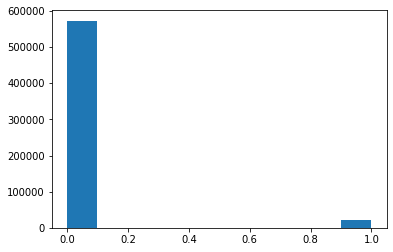

Percentage of claims filed : 3.6447517859182947 %


In [30]:
# Distribution of target variable
import matplotlib.pyplot as plt
plt.hist(data_raw['target'])
plt.show()

print('Percentage of claims filed :' , str(np.sum(data_raw['target'])/data_raw.shape[0]*100), '%')

But before jumping into balancing the data let's **look at the NA's, which in this dataset are denoted as -1**.

In [31]:
nas = np.sum(data_raw == -1)/len(data_raw) *100
print("The percentage of missing values is")
print (nas[nas>0].sort_values(ascending = False))

The percentage of missing values is
ps_car_03_cat    69.089837
ps_car_05_cat    44.782531
ps_reg_03        18.106490
ps_car_14         7.160474
ps_car_07_cat     1.930237
ps_ind_05_cat     0.975955
ps_car_09_cat     0.095596
ps_ind_02_cat     0.036290
ps_car_01_cat     0.017977
ps_ind_04_cat     0.013945
ps_car_11         0.000840
ps_car_02_cat     0.000840
ps_car_12         0.000168
dtype: float64


Now, for categorical variables we will create dummy variables (aka **one-hot encoding**)

In [32]:
# make a copy of the initial dataset
data_clean = data_raw.copy()
#data_clean.columns
cat_cols = [c for c in data_clean.columns if c.endswith('cat')]
for column in cat_cols:
    temp=pd.get_dummies(data_clean[column], prefix=column, prefix_sep='_')
    data_clean=pd.concat([data_clean,temp],axis=1)
    data_clean=data_clean.drop([column],axis=1)

print('data_clean shape is:',data_clean.shape)

data_clean shape is: (595212, 229)


In [33]:
# Impute missing values with medians

num_cols = ['ps_reg_03','ps_car_14', 'ps_car_11', 'ps_car_12' ]

for n in num_cols:
    dummy_name = str(n) + 'NA'
    data_clean[dummy_name] = (data_clean[n]==-1).astype(int)
    med = data_clean[data_clean[n]!=-1][n].median()
    data_clean.loc[data_clean[n]==-1,n] = med
    

In [34]:
#Make transformation to ps_car_13, as suggested here: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/41489
data_clean['ps_car_13_trans'] = round(data_clean['ps_car_13']* data_clean['ps_car_13']* 90000,2)

The target variable is highly unbalanced. This can be improved by either undersampling values with target = 0 or oversampling values with target = 1. Because there is a rather large training set, we opt for the undersampling.



**Undersampling**:
Let's take 25% of abundant data (target = 0) and stack together with the rare data (target = 1)




In [35]:
sub_df_0= data_clean[(data_clean['target']==0)]
sub_df_1= data_clean[(data_clean['target']==1)]
sub_df_1.shape

(21694, 234)

In [36]:
sub_df = sub_df_0.sample(frac = 0.25, random_state = 42)
data_sub = pd.concat([sub_df_1,sub_df])

https://www.kaggle.com/gpreda/porto-seguro-exploratory-analysis-and-prediction

I ran the predictive model with various parameters but it did not work well.
It gave a CV score of 0.27.

Moving on with other models:

##  APPROACH 2 - GENETIC ALGORITHM






In [37]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import lightgbm as lgb
import numpy as np
import pickle

train_data = pd.read_csv("train.csv/train.csv")
test_data = pd.read_csv("test.csv/test.csv")

We will be using gini_lgb during training and gini_normalizedc to score the model predictions

In [38]:
def ginic(actual, pred):
    n = len(actual)
    a_s = actual[np.argsort(pred)]
    a_c = a_s.cumsum()
    giniSum = a_c.sum() / a_c[-1] - (n + 1) / 2.0
    return giniSum / n
 
def gini_normalizedc(a, p):
    if p.ndim == 2:
        p = p[:,1] 
    return ginic(a, p) / ginic(a, a)

def gini_lgb(preds, dtrain):  
    actuals = np.array(dtrain.get_label())   
    return 'gini', gini_normalizedc(actuals, preds), True


This is the main training function.

Please note that divide by zero gives you NaN which is perfectly fine for tree algorithms. However, if you want to use Neural Networks you should instead do something like: value = a / (b + epsilon) or just add some ifs

Implemenetd target encoding with min_samples_leafand smoothing from kernels, type and level of noise was found after some experiments.

copy() was used because I needed to perform feature engineering here, in the inner loop - you can do math feature engineering outside, but for target encoding you can do it only here - validation set is not used in target mean/count!, additional memory optimization can be done by using smaller types for columns (like many kernels do)

In [39]:
def perform_single_train(data, hyper):

    X_train = data["X_train"]
    y_train = data["y_train"]
    X_valid = data["X_valid"]
    y_valid = data["y_valid"]
    X_test = data["X_test"]
    
    lgb_pars = hyper["lgb_pars"]
    features = hyper["features"]
    
    rounds = hyper["rounds"]
    early = hyper["early"]
    noise_level = hyper["noise_level"]
    smoothing = hyper["smoothing"]
    min_samples_leaf= hyper["min_samples_leaf"]

    X_data = X_train.copy()
    X_data["target"] = y_train

    X_train_c=X_train.copy()
    X_valid_c=X_valid.copy()
    X_test_c=X_test.copy()

    for f in features:
        s = f.split("_add_")
        if (len(s) == 2):
            c1 = s[0]
            c2 = s[1]
            X_train[f] = X_train_c[c1] + X_train_c[c2]
            X_valid[f] = X_valid_c[c1] + X_valid_c[c2]
            X_test[f] = X_test_c[c1] + X_test_c[c2]

        s = f.split("_sub_")
        if (len(s) == 2):
            c1 = s[0]
            c2 = s[1]
            X_train[f] = X_train_c[c1] - X_train_c[c2]
            X_valid[f] = X_valid_c[c1] - X_valid_c[c2]
            X_test[f] = X_test_c[c1] - X_test_c[c2]

        s = f.split("_mul_")
        if (len(s) == 2):
            c1 = s[0]
            c2 = s[1]
            X_train[f] = X_train_c[c1] * X_train_c[c2]
            X_valid[f] = X_valid_c[c1] * X_valid_c[c2]
            X_test[f] = X_test_c[c1] * X_test_c[c2]

        s = f.split("_div_")
        if (len(s) == 2):
            c1 = s[0]
            c2 = s[1]
            X_train[f] = X_train_c[c1] / X_train_c[c2]
            X_valid[f] = X_valid_c[c1] / X_valid_c[c2]
            X_test[f] = X_test_c[c1] / X_test_c[c2]

        s = f.split("_mean_")                    
        if (len(s) > 1):
            if (s[0] == '0'):
                s.remove('0')

            averages = X_data.groupby(s)["target"].agg(["mean", "count"])
            smoothing_v = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
            averages[f] = X_data["target"].mean() * (1 - smoothing_v) + averages["mean"] * smoothing_v
            averages.drop(["mean", "count"], axis=1, inplace=True)

            np.random.seed(42)
            noise = np.random.randn(len(averages[f])) * noise_level
            averages[f] = averages[f] + noise

            X_train = pd.merge(X_train, averages, how='left', left_on=s, right_index=True)
            X_valid = pd.merge(X_valid, averages, how='left', left_on=s, right_index=True)
            X_test = pd.merge(X_test, averages, how='left', left_on=s, right_index=True)                       
            
    X_train_subset=X_train[features]
    X_valid_subset=X_valid[features]
    X_test_subset=X_test[features]
    
    lgb_train = lgb.Dataset(X_train_subset, y_train)
    lgb_eval = lgb.Dataset(X_valid_subset, y_valid, reference=lgb_train)

    model = lgb.train(lgb_pars,
            lgb_train,
            num_boost_round=rounds,
            valid_sets=lgb_eval,
            early_stopping_rounds=early,
            feval=gini_lgb,
            verbose_eval=100)

    p_train = model.predict(X_train_subset, num_iteration=model.best_iteration)            
    p_valid = model.predict(X_valid_subset, num_iteration=model.best_iteration)            
    p_test = model.predict(X_test_subset, num_iteration=model.best_iteration)   

    train_score = gini_normalizedc(y_train, p_train) 
    valid_score = gini_normalizedc(y_valid, p_valid)     

    return [train_score, valid_score, p_test]


Here we do kfold split and write results to the file. 
I tried saving train/validation results too for ensembling, however, average was always better than ensembling so here only test results are stored.


In [40]:
def perform_full(X, y, X_test, hyper, prefix):    
    scores = []   
    kfold = hyper["kfold"]
    
    skf = StratifiedKFold(n_splits=kfold, random_state=42)
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
        y_train, y_valid = y[train_index], y[test_index]
        
        X_test_c = X_test.copy()

        data = {"X_train": X_train,
                "y_train": y_train,
                "X_valid": X_valid,
                "y_valid": y_valid,
                "X_test": X_test_c
                }
        
        [train_score, valid_score, p_test] = perform_single_train(data, hyper)

        with open("test_"+prefix+str(i)+".pkl", 'wb') as f:
            pickle.dump(p_test,f)

        scores.append([train_score, valid_score])
        
    return scores     


This is one feature set generated with the genetic algorithm. It was selected here because on Public LB it scored 0.28330 (with reference to the notebooks cited in the end). Of course now we all know that Public LB is not very good measure, so on private it scores only 0.29045.

If you want to play - it is very likely that you can increase score simply by removing some of these features. My top solutions (according to local CVs) were 0.289, then I started removing single feature from each good solutions and in the end I had collection of 0.290 solutions.

In [41]:

best_features = ['0_mean_ps_car_05_cat',
 '0_mean_ps_car_10_cat',
 '0_mean_ps_car_12',
 '0_mean_ps_ind_04_cat',
 '0_mean_ps_ind_17_bin',
 '0_mean_ps_ind_18_bin',
 'ps_car_01_cat',
 'ps_car_01_cat_add_ps_car_02_cat',
 'ps_car_01_cat_mean_ps_car_07_cat',
 'ps_car_01_cat_mean_ps_ind_18_bin',
 'ps_car_02_cat',
 'ps_car_02_cat_add_ps_ind_12_bin',
 'ps_car_02_cat_mul_ps_ind_09_bin',
 'ps_car_02_cat_sub_ps_car_08_cat',
 'ps_car_03_cat',
 'ps_car_03_cat_add_ps_ind_05_cat',
 'ps_car_03_cat_div_ps_ind_11_bin',
 'ps_car_03_cat_mean_ps_ind_12_bin_mean_ps_ind_16_bin',
 'ps_car_04_cat',
 'ps_car_04_cat_mean_ps_ind_04_cat',
 'ps_car_04_cat_mean_ps_ind_14',
 'ps_car_05_cat',
 'ps_car_05_cat_add_ps_ind_10_bin',
 'ps_car_05_cat_mean_ps_ind_13_bin',
 'ps_car_06_cat',
 'ps_car_06_cat_add_ps_reg_02',
 'ps_car_07_cat',
 'ps_car_07_cat_mean_ps_car_10_cat_mean_ps_ind_10_bin',
 'ps_car_07_cat_mean_ps_ind_02_cat_mean_ps_ind_10_bin',
 'ps_car_07_cat_mean_ps_ind_14',
 'ps_car_07_cat_sub_ps_ind_09_bin',
 'ps_car_08_cat',
 'ps_car_08_cat_mul_ps_ind_17_bin',
 'ps_car_09_cat',
 'ps_car_09_cat_mean_ps_car_10_cat_mean_ps_ind_13_bin',
 'ps_car_09_cat_mean_ps_ind_05_cat',
 'ps_car_09_cat_mul_ps_car_10_cat',
 'ps_car_09_cat_sub_ps_ind_03',
 'ps_car_10_cat',
 'ps_car_10_cat_mul_ps_ind_07_bin',
 'ps_car_10_cat_sub_ps_ind_12_bin',
 'ps_car_11',
 'ps_car_11_cat',
 'ps_car_11_div_ps_ind_02_cat',
 'ps_car_11_mean_ps_ind_02_cat',
 'ps_car_11_mean_ps_ind_10_bin',
 'ps_car_11_mean_ps_ind_12_bin',
 'ps_car_11_mean_ps_ind_12_bin_mean_ps_ind_16_bin',
 'ps_car_12',
 'ps_car_13',
 'ps_car_14',
 'ps_car_15',
 'ps_car_15_add_ps_ind_01',
 'ps_car_15_add_ps_ind_11_bin',
 'ps_car_15_div_ps_ind_14',
 'ps_car_15_mul_ps_ind_01',
 'ps_ind_01',
 'ps_ind_01_div_ps_ind_16_bin',
 'ps_ind_01_mean_ps_ind_09_bin',
 'ps_ind_01_mean_ps_ind_11_bin',
 'ps_ind_01_sub_ps_ind_03',
 'ps_ind_02_cat',
 'ps_ind_02_cat_add_ps_reg_01',
 'ps_ind_02_cat_mean_ps_ind_11_bin',
 'ps_ind_02_cat_mean_ps_ind_12_bin',
 'ps_ind_02_cat_mean_ps_ind_14',
 'ps_ind_02_cat_mul_ps_ind_08_bin',
 'ps_ind_02_cat_mul_ps_ind_11_bin',
 'ps_ind_03',
 'ps_ind_03_mean_ps_ind_15',
 'ps_ind_03_mul_ps_ind_11_bin',
 'ps_ind_04_cat',
 'ps_ind_04_cat_mul_ps_ind_12_bin',
 'ps_ind_04_cat_mul_ps_ind_17_bin',
 'ps_ind_04_cat_sub_ps_ind_11_bin',
 'ps_ind_05_cat',
 'ps_ind_05_cat_add_ps_ind_14',
 'ps_ind_05_cat_add_ps_ind_17_bin',
 'ps_ind_05_cat_mean_ps_ind_13_bin',
 'ps_ind_05_cat_mean_ps_reg_01',
 'ps_ind_06_bin',
 'ps_ind_06_bin_div_ps_reg_02',
 'ps_ind_06_bin_mean_ps_ind_13_bin',
 'ps_ind_06_bin_sub_ps_ind_17_bin',
 'ps_ind_07_bin',
 'ps_ind_07_bin_mean_ps_ind_12_bin',
 'ps_ind_08_bin',
 'ps_ind_08_bin_add_ps_ind_17_bin',
 'ps_ind_08_bin_mean_ps_ind_13_bin_mean_ps_ind_14',
 'ps_ind_08_bin_mean_ps_reg_01',
 'ps_ind_09_bin',
 'ps_ind_09_bin_add_ps_ind_15',
 'ps_ind_09_bin_mul_ps_ind_17_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_11_bin_div_ps_ind_12_bin',
 'ps_ind_12_bin',
 'ps_ind_12_bin_mul_ps_reg_03',
 'ps_ind_13_bin',
 'ps_ind_13_bin_div_ps_reg_03',
 'ps_ind_13_bin_sub_ps_reg_03',
 'ps_ind_14',
 'ps_ind_14_div_ps_reg_01',
 'ps_ind_15',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin',
 'ps_reg_01',
 'ps_reg_01_mean_ps_ind_18_bin',
 'ps_reg_02',
 'ps_reg_03']



Now let's perform actual training with best_features and store results to test_kaggle_kernel files.

In [42]:
X = train_data.drop(["id","target"],axis=1)
y = train_data["target"].values 
X_test = test_data.drop(["id"],axis=1)

lgb_pars = {
    'max_depth': 4,
    'min_data_in_leaf': 20,
    'min_sum_hessian_in_leaf': 1e-3,
    'feature_fraction': 0.47,
    'bagging_fraction': 0.87,
    'bagging_freq': 10,
    'lambda_l1': 8.0,    
    'lambda_l2': 13.0,    
    'min_split_gain': 0,
    'max_bin': 255,
    'min_data_in_bin': 3,
    'learning_rate': 0.08,
    'metric': {'gini_lgb'},
    'objective': "binary"
}

hyper = {"rounds": 1000,
         "early": 100,
         "lgb_pars": lgb_pars,
         "features": best_features,
         "noise_level": 0.1,
         "kfold" : 5,
         "smoothing": 30.0,
         "min_samples_leaf": 300}

result = perform_full(X, y, X_test, hyper, "kaggle_kernel_")



Training until validation scores don't improve for 100 rounds.
[100]	valid_0's gini: 0.279833
[200]	valid_0's gini: 0.285346
[300]	valid_0's gini: 0.286769
Early stopping, best iteration is:
[262]	valid_0's gini: 0.287369
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's gini: 0.281464
[200]	valid_0's gini: 0.286579
[300]	valid_0's gini: 0.286242
Early stopping, best iteration is:
[220]	valid_0's gini: 0.287102
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's gini: 0.280655
[200]	valid_0's gini: 0.286499
[300]	valid_0's gini: 0.28735
[400]	valid_0's gini: 0.288236
Early stopping, best iteration is:
[394]	valid_0's gini: 0.288411
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's gini: 0.286736
[200]	valid_0's gini: 0.291234
[300]	valid_0's gini: 0.294206
[400]	valid_0's gini: 0.293933
Early stopping, best iteration is:
[316]	valid_0's gini: 0.294679
Training until validation scores don't improve for 

This is how I average results from stored files. 
I tried other ways - like harmonic mean or rank mean. 
Results (on public LB) were similar.
When averaging 100 or 500 kernels rank mean is very tricky, because you need to have them all in the memory, so the algorithm is written to split each file into pieces and perform rank mean on each piece.
Simple average is easy and works for any number of files.


In [44]:
predictions = []

kfold = 5

for i in range(kfold):    
    with open("test_kaggle_kernel_"+str(i)+".pkl", 'rb') as f:
        pred = pickle.load(f)        
    predictions.append(pred)

final_prediction = np.zeros(predictions[0].shape[0])
for i in range(kfold):
    pred = predictions[i]
    final_prediction += pred / kfold

submission=pd.DataFrame()
submission["id"] = test_data["id"]
submission["target"] = final_prediction
submission.set_index("id", inplace=True)
#submission.to_csv("genetic.csv")  
submission.to_csv("Approach2.csv") 
submission["target"].describe()

# Scores on LB:
# 0.28955 Private
# 0.28196 Public

count    892816.000000
mean          0.036372
std           0.020251
min           0.006133
25%           0.023065
50%           0.031567
75%           0.043798
max           0.492823
Name: target, dtype: float64

### APPROACH 3 - LGBM MODEL 

Best Scoring Model
PrivateLB  0.29090
PublicLB 0.28536

In [45]:
import lightgbm as lgbm
from scipy import sparse as ssp
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def Gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]

    # sort rows on prediction column
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:, 0].argsort()][::-1, 0]
    pred_order = arr[arr[:, 1].argsort()][::-1, 0]

    # get Lorenz curves
    L_true = np.cumsum(true_order) * 1. / np.sum(true_order)
    L_pred = np.cumsum(pred_order) * 1. / np.sum(pred_order)
    L_ones = np.linspace(1 / n_samples, 1, n_samples)

    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)

    # normalize to true Gini coefficient
    return G_pred * 1. / G_true

cv_only = True
save_cv = True
full_train = False

def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', Gini(labels, preds), True

train = pd.read_csv('train.csv/train.csv')
train_label = train['target']
train_id = train['id']
test = pd.read_csv('test.csv/test.csv')
test_id = test['id']

NFOLDS = 5
kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=218)

y = train['target'].values
drop_feature = [
    'id',
    'target'
]

X = train.drop(drop_feature,axis=1)
feature_names = X.columns.tolist()
cat_features = [c for c in feature_names if ('cat' in c and 'count' not in c)]
num_features = [c for c in feature_names if ('cat' not in c and 'calc' not in c)]

train['missing'] = (train==-1).sum(axis=1).astype(float)
test['missing'] = (test==-1).sum(axis=1).astype(float)
num_features.append('missing')

for c in cat_features:
    le = LabelEncoder()
    le.fit(train[c])
    train[c] = le.transform(train[c])
    test[c] = le.transform(test[c])

enc = OneHotEncoder()
enc.fit(train[cat_features])
X_cat = enc.transform(train[cat_features])
X_t_cat = enc.transform(test[cat_features])

ind_features = [c for c in feature_names if 'ind' in c]
count=0
for c in ind_features:
    if count==0:
        train['new_ind'] = train[c].astype(str)+'_'
        test['new_ind'] = test[c].astype(str)+'_'
        count+=1
    else:
        train['new_ind'] += train[c].astype(str)+'_'
        test['new_ind'] += test[c].astype(str)+'_'

cat_count_features = []
for c in cat_features+['new_ind']:
    d = pd.concat([train[c],test[c]]).value_counts().to_dict()
    train['%s_count'%c] = train[c].apply(lambda x:d.get(x,0))
    test['%s_count'%c] = test[c].apply(lambda x:d.get(x,0))
    cat_count_features.append('%s_count'%c)

train_list = [train[num_features+cat_count_features].values,X_cat,]
test_list = [test[num_features+cat_count_features].values,X_t_cat,]

X = ssp.hstack(train_list).tocsr()
X_test = ssp.hstack(test_list).tocsr()

learning_rate = 0.1
num_leaves = 15
min_data_in_leaf = 2000
feature_fraction = 0.6
num_boost_round = 10000
params = {"objective": "binary",
          "boosting_type": "gbdt",
          "learning_rate": learning_rate,
          "num_leaves": num_leaves,
           "max_bin": 256,
          "feature_fraction": feature_fraction,
          "verbosity": 0,
          "drop_rate": 0.1,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 10,
          "min_child_weight": 150,
          "min_split_gain": 0,
          "subsample": 0.9
          }

x_score = []
final_cv_train = np.zeros(len(train_label))
final_cv_pred = np.zeros(len(test_id))
for s in range(16):
    cv_train = np.zeros(len(train_label))
    cv_pred = np.zeros(len(test_id))

    params['seed'] = s

    if cv_only:
        kf = kfold.split(X, train_label)

        best_trees = []
        fold_scores = []

        for i, (train_fold, validate) in enumerate(kf):
            X_train, X_validate, label_train, label_validate = \
                X[train_fold, :], X[validate, :], train_label[train_fold], train_label[validate]
            dtrain = lgbm.Dataset(X_train, label_train)
            dvalid = lgbm.Dataset(X_validate, label_validate, reference=dtrain)
            bst = lgbm.train(params, dtrain, num_boost_round, valid_sets=dvalid, feval=evalerror, verbose_eval=100,
                            early_stopping_rounds=100)
            best_trees.append(bst.best_iteration)
            cv_pred += bst.predict(X_test, num_iteration=bst.best_iteration)
            cv_train[validate] += bst.predict(X_validate)

            score = Gini(label_validate, cv_train[validate])
            print(score)
            fold_scores.append(score)

        cv_pred /= NFOLDS
        final_cv_train += cv_train
        final_cv_pred += cv_pred

        print("cv score:")
        print(Gini(train_label, cv_train))
        print("current score:", Gini(train_label, final_cv_train / (s + 1.)), s+1)
        print(fold_scores)
        print(best_trees, np.mean(best_trees))

        x_score.append(Gini(train_label, cv_train))

print(x_score)
#pd.DataFrame({'id': test_id, 'target': final_cv_pred / 16.}).to_csv('lgbm3_pred_avg.csv', index=False)
pd.DataFrame({'id': test_id, 'target': final_cv_pred / 16.}).to_csv('Approach3.csv', index=False)
pd.DataFrame({'id': train_id, 'target': final_cv_train / 16.}).to_csv('lgbm3_cv_avg.csv', index=False)


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.15159	valid_0's gini: 0.291863
[200]	valid_0's binary_logloss: 0.151468	valid_0's gini: 0.29491
Early stopping, best iteration is:
[189]	valid_0's binary_logloss: 0.151457	valid_0's gini: 0.295075
0.2950745960037473
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.152123	valid_0's gini: 0.272679
[200]	valid_0's binary_logloss: 0.152038	valid_0's gini: 0.275581
[300]	valid_0's binary_logloss: 0.152089	valid_0's gini: 0.276195
Early stopping, best iteration is:
[224]	valid_0's binary_logloss: 0.152015	valid_0's gini: 0.276851
0.27685121636649
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.151974	valid_0's gini: 0.277978
[200]	valid_0's binary_logloss: 0.151926	valid_0's gini: 0.280307
Early stopping, best iteration is:
[139]	valid_0's binary_logloss: 0.151902	valid_0's gini: 0.280395
0.2803950421

### **CONCLUSION**

# Approach 1 :

I started with EDA and following a LGBM model after understanding the features, transforming the cateogry features to dummy variables, computing the gini, creating an ensemble and passing 2 different set of parameters to the model.

It gave me the score:

PrivateLB: 0.28950
Public LB: 0.28329

# Approach 2:

I moved ahead with more deep dives into the analysis of data. I had to undersample it to avoid imbalance. With reference to kernels, the CV score was low so moved ahead with a genetic approach. The genetic appproach used lgbm model and performed stratifiedKfold to get a better score.

PrivateLB: 0.28955
PublicLB: 0.28196 

# Approach 3:

I finally performed LGBM Model with the best set of parameters to achieve best score.

PrivateLB: 0.29090
PublicLB: 0.28536



**LGBM Model with StratifiedKFold and a learning rate of 0.1 gives the best performance as per my understanding of various models and kernels.**

**CONTRIBUTIONS STATEMENT**

Approach 1 was my view at the competition with my skills and understandings. 
Implemented stratifiedKfold along with different set of parameters for lgbm model to get an accuracy score nearest to the best model I picked from the kernels.

Went ahead to see how a learning rate of 0.2 gave different results compared to a learning rate of 0.1 after running models with various set of parameters.

**CITATIONS**

Referred code from the following links:


https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/44659

https://www.kaggle.com/gpreda/porto-seguro-exploratory-analysis-and-prediction

https://github.com/xiaozhouwang/kaggle-porto-seguro/blob/master/code/gbm_model291.py

All other code is written by me.

Copyright 2020 Gauri Verma

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.